<a href="https://colab.research.google.com/github/nisharani-dev/real_vs_ai_image_classifier/blob/main/real_vs_ai_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# 1️⃣ Install Kaggle API tool
!pip install -q kaggle

# 2️⃣ Move your kaggle.json to the right place
import os
from google.colab import files

# Upload kaggle.json from your system
files.upload()  # Will prompt to choose kaggle.json

# Put it in ~/.kaggle and set permissions
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

# 3️⃣ Download the dataset
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

# 4️⃣ Unzip it into dataset/ folder
!unzip -q 140k-real-and-fake-faces.zip -d dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
140k-real-and-fake-faces.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [8]:
import os

for root, dirs, files in os.walk("dataset"):
    print(root, len(files))


dataset 3
dataset/real_vs_fake 0
dataset/real_vs_fake/real-vs-fake 0
dataset/real_vs_fake/real-vs-fake/train 0
dataset/real_vs_fake/real-vs-fake/train/real 50000
dataset/real_vs_fake/real-vs-fake/train/fake 50000
dataset/real_vs_fake/real-vs-fake/valid 0
dataset/real_vs_fake/real-vs-fake/valid/real 10000
dataset/real_vs_fake/real-vs-fake/valid/fake 10000
dataset/real_vs_fake/real-vs-fake/test 0
dataset/real_vs_fake/real-vs-fake/test/real 10000
dataset/real_vs_fake/real-vs-fake/test/fake 10000


In [9]:
import tensorflow as tf

DATASET_ROOT = "dataset/real_vs_fake/real-vs-fake"

IMG_SIZE = (128, 128)  # smaller size to save RAM
BATCH_SIZE = 32

def load_subset(dir_path, max_images=None):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dir_path,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    if max_images:
        dataset = dataset.take(max_images // BATCH_SIZE)
    return dataset

train_dataset = load_subset(f"{DATASET_ROOT}/train", max_images=10000)  # 10k images
valid_dataset = load_subset(f"{DATASET_ROOT}/valid", max_images=2000)   # 2k images
test_dataset  = load_subset(f"{DATASET_ROOT}/test", max_images=2000)    # 2k images

# Optional: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [10]:
# -----------------------------
# STEP 0: Imports
# -----------------------------
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# -----------------------------
# STEP 1: CONFIG - Dataset paths
# -----------------------------
REAL_DIR = "dataset/real_vs_fake/real-vs-fake/train/real"
FAKE_DIR = "dataset/real_vs_fake/real-vs-fake/train/fake"

# Limit number of images to avoid RAM issues
N_SAMPLES = 1000  # per class

# -----------------------------
# STEP 2: HELPER FUNCTIONS
# -----------------------------
def extract_fft_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    return [np.mean(magnitude_spectrum), np.var(magnitude_spectrum)]

def extract_lbp_features(img, P=8, R=1):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.tolist()

def extract_color_stats(img):
    means = cv2.mean(img)[:3]
    vars_ = [np.var(img[:,:,i]) for i in range(3)]
    return list(means) + vars_

def extract_noise_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    noise = gray - blur
    return [np.mean(noise), np.var(noise)]

def extract_features(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    features = []
    features += extract_fft_features(img)
    features += extract_lbp_features(img)
    features += extract_color_stats(img)
    features += extract_noise_features(img)
    return features

# -----------------------------
# STEP 3: LOAD DATA & EXTRACT FEATURES
# -----------------------------
data = []
labels = []

real_imgs = os.listdir(REAL_DIR)[:N_SAMPLES]
fake_imgs = os.listdir(FAKE_DIR)[:N_SAMPLES]

print("Extracting features from REAL images...")
for img_name in tqdm(real_imgs):
    img_path = os.path.join(REAL_DIR, img_name)
    features = extract_features(img_path)
    data.append(features)
    labels.append(1)  # 1 for real

print("Extracting features from FAKE images...")
for img_name in tqdm(fake_imgs):
    img_path = os.path.join(FAKE_DIR, img_name)
    features = extract_features(img_path)
    data.append(features)
    labels.append(0)  # 0 for fake

data = np.array(data)
labels = np.array(labels)

# -----------------------------
# STEP 4: TRAIN MODEL
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# -----------------------------
# STEP 5: EVALUATE
# -----------------------------
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Extracting features from REAL images...


100%|██████████| 1000/1000 [00:05<00:00, 180.39it/s]


Extracting features from FAKE images...


100%|██████████| 1000/1000 [00:08<00:00, 120.09it/s]


Accuracy: 0.605
              precision    recall  f1-score   support

           0       0.60      0.65      0.62       200
           1       0.62      0.56      0.59       200

    accuracy                           0.60       400
   macro avg       0.61      0.60      0.60       400
weighted avg       0.61      0.60      0.60       400



In [11]:
from google.colab import files

# Upload an image
uploaded = files.upload()

for fname in uploaded.keys():
    img_path = fname
    features = extract_features(img_path)  # reuse our earlier function
    features = np.array(features).reshape(1, -1)
    pred = clf.predict(features)[0]
    label = "Real" if pred == 1 else "AI-generated"
    print(f"Image: {fname} → Prediction: {label}")


Saving fake test.jpg to fake test.jpg
Image: fake test.jpg → Prediction: AI-generated


In [12]:
from google.colab import files

# Upload an image
uploaded = files.upload()

for fname in uploaded.keys():
    img_path = fname
    features = extract_features(img_path)  # reuse our earlier function
    features = np.array(features).reshape(1, -1)
    pred = clf.predict(features)[0]
    label = "Real" if pred == 1 else "AI-generated"
    print(f"Image: {fname} → Prediction: {label}")


Saving ChatGPT Image Aug 12, 2025, 08_01_02 PM.png to ChatGPT Image Aug 12, 2025, 08_01_02 PM (2).png
Image: ChatGPT Image Aug 12, 2025, 08_01_02 PM (2).png → Prediction: Real


In [13]:
# Install Kaggle API
!pip install kaggle --quiet

from google.colab import files
files.upload()  # Upload kaggle.json

# Setup kaggle.json
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Create directory for extra datasets
!mkdir -p extra_data

# Download datasets (note: -p is lowercase)
!kaggle datasets download -d shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset -p extra_data
!kaggle datasets download -d hamzaboulahia/hardfakevsrealfaces -p extra_data
!kaggle datasets download -d dullaz/1m-ai-generated-faces-128x128 -p extra_data
!kaggle datasets download -d jessicali9530/celeba-dataset -p extra_data  # Optional real set

# Unzip everything
!unzip -q "extra_data/*.zip" -d extra_data



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset
License(s): apache-2.0
 71% 82.0M/116M [00:00<00:00, 855MB/s]
100% 116M/116M [00:00<00:00, 739MB/s] 
Dataset URL: https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces
License(s): CC0-1.0
  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 440MB/s]
Dataset URL: https://www.kaggle.com/datasets/dullaz/1m-ai-generated-faces-128x128
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 4.08G/4.08G [00:22<00:00, 259MB/s]
100% 4.08G/4.08G [00:22<00:00, 196MB/s]
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 97% 1.29G/1.33G [00:15<00:01, 35.5MB/s]
100% 1.33G/1.33G [00:15<00:00, 94.9MB/s]

4 archives were successfully processed.


# Download the Alessandra Sala AI vs Human dataset
!kaggle datasets download -d alessandrasala79/ai-vs-human-generated-dataset -p extra_data

# Unzip it
!unzip -q extra_data/ai-vs-human-generated-dataset.zip -d extra_data/alessandrasala79


In [14]:
# ------------------------------
# Forensic pipeline (combined)
# - uses existing folders under dataset/real_vs_fake/real-vs-fake
# - samples a small balanced subset per class
# - extracts forensic features (FFT energy ratio, LBP, color stats, noise residual)
# - trains RandomForest, evaluates, saves model + scaler + features CSV
# ------------------------------

# 0) Install required packages (run once)
!pip install -q scikit-image pywavelets tqdm joblib

# 1) Imports
import os, glob, random, shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from skimage.feature import local_binary_pattern
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

# 2) Configuration - change these if needed
ROOT = "dataset/real_vs_fake/real-vs-fake"   # detected dataset root in your workspace
SAMPLE_PER_CLASS = 2500   # how many images per class to sample (adjust down if RAM issues)
RESIZE = (128, 128)       # resize for feature extraction
FEATURES_CSV = "features_merged.csv"
MODEL_FILE = "rf_forensic_model.joblib"
SCALER_FILE = "rf_forensic_scaler.joblib"
RANDOM_SEED = 42

# 3) Auto-detect available folders
real_dirs = []
fake_dirs = []
candidates = [
    os.path.join(ROOT, "train", "real"),
    os.path.join(ROOT, "valid", "real"),
    os.path.join(ROOT, "test", "real"),
    os.path.join(ROOT, "train", "fake"),
    os.path.join(ROOT, "valid", "fake"),
    os.path.join(ROOT, "test", "fake"),
]
for d in candidates:
    if os.path.isdir(d):
        if d.endswith(os.path.join("train","real")) or d.endswith(os.path.join("valid","real")) or d.endswith(os.path.join("test","real")):
            real_dirs.append(d)
        if d.endswith(os.path.join("train","fake")) or d.endswith(os.path.join("valid","fake")) or d.endswith(os.path.join("test","fake")):
            fake_dirs.append(d)

# fallback: search recursively
if not real_dirs or not fake_dirs:
    for d in glob.glob(os.path.join(ROOT, "**"), recursive=True):
        if os.path.isdir(d) and os.path.basename(d).lower() in ("real", "human"):
            real_dirs.append(d)
        if os.path.isdir(d) and os.path.basename(d).lower() in ("fake", "ai", "generated"):
            fake_dirs.append(d)

if not real_dirs or not fake_dirs:
    raise FileNotFoundError("Could not find 'real' or 'fake' image folders under your dataset root. Check ROOT path.")

print("Discovered real dirs:", real_dirs)
print("Discovered fake dirs:", fake_dirs)

# 4) Collect image paths and sample balanced subset
def collect_images(dirs, exts=("*.jpg","*.jpeg","*.png")):
    paths = []
    for d in dirs:
        for e in exts:
            paths.extend(glob.glob(os.path.join(d, "**", e), recursive=True))
    return paths

real_paths = collect_images(real_dirs)
fake_paths = collect_images(fake_dirs)

random.seed(RANDOM_SEED)
real_sample = random.sample(real_paths, min(SAMPLE_PER_CLASS, len(real_paths)))
fake_sample = random.sample(fake_paths, min(SAMPLE_PER_CLASS, len(fake_paths)))

print(f"Collected real: {len(real_paths)} total, sampling {len(real_sample)}")
print(f"Collected fake: {len(fake_paths)} total, sampling {len(fake_sample)}")

# Build dataframe of samples
samples = pd.DataFrame({
    "path": real_sample + fake_sample,
    "label": ["real"] * len(real_sample) + ["fake"] * len(fake_sample)
})

# shuffle
samples = samples.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
print("Total samples to process:", len(samples))

# 5) Feature extraction helpers
def read_image(path, resize=RESIZE):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, resize, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    return img

def channel_stats(img):
    # img float RGB [0,1]
    r = img[...,0].ravel()
    g = img[...,1].ravel()
    b = img[...,2].ravel()
    feats = []
    feats += [r.mean(), r.std(), g.mean(), g.std(), b.mean(), b.std()]
    # channel correlations (safe guard NaNs)
    def corr(a,b):
        if np.std(a)==0 or np.std(b)==0:
            return 0.0
        return float(np.corrcoef(a,b)[0,1])
    feats += [corr(r,g), corr(r,b), corr(g,b)]
    return feats  # length 9

def fft_highfreq_ratio(img_gray):
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    h,w = mag.shape
    cy, cx = h//2, w//2
    radius = min(cy,cx)*0.25
    y,x = np.ogrid[:h, :w]
    dist = np.sqrt((y-cy)**2 + (x-cx)**2)
    high_mask = dist > radius
    total = mag.sum() + 1e-12
    high_energy = mag[high_mask].sum()
    return float(high_energy / total)

def lbp_hist(img_gray, P=8, R=1):
    lbp = local_binary_pattern((img_gray*255).astype(np.uint8), P, R, method='uniform')
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins+1), density=True)
    return hist.tolist()  # length n_bins

def wavelet_detail_energy(img_gray, wave='db1'):
    # DWT 1-level
    coeffs = pywt.dwt2(img_gray, wave)
    cA, (cH, cV, cD) = coeffs
    energies = [float(np.mean(np.abs(cH))), float(np.mean(np.abs(cV))), float(np.mean(np.abs(cD)))]
    return energies

def noise_residual_stats(img_gray):
    blur = cv2.GaussianBlur((img_gray*255).astype(np.uint8), (3,3), 0).astype(np.float32)/255.0
    resid = img_gray - blur
    return [float(resid.mean()), float(resid.std())]

def extract_features(path):
    img = read_image(path)
    img_gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0
    feats = []
    feats += channel_stats(img)
    feats.append(fft_highfreq_ratio(img_gray))
    feats += lbp_hist(img_gray, P=8, R=1)
    feats += wavelet_detail_energy(img_gray, wave='db1')
    feats += noise_residual_stats(img_gray)
    return np.array(feats, dtype=np.float32)

# 6) Build or load cached features
if os.path.exists(FEATURES_CSV):
    print("Loading existing feature cache:", FEATURES_CSV)
    feats_df = pd.read_csv(FEATURES_CSV)
else:
    rows = []
    print("Extracting features for all sampled images. This may take a few minutes...")
    for idx, row in tqdm(samples.iterrows(), total=len(samples)):
        p = row['path']
        lbl = row['label']
        try:
            feats = extract_features(p)
        except Exception as e:
            print("Skipping (read error):", p, e)
            continue
        entry = {f"f{i}": float(feats[i]) for i in range(len(feats))}
        entry['label'] = lbl
        entry['path'] = p
        rows.append(entry)
    feats_df = pd.DataFrame(rows)
    feats_df.to_csv(FEATURES_CSV, index=False)
    print("Features saved to", FEATURES_CSV)

print("Feature matrix shape:", feats_df.shape)

# 7) Prepare X,y and train/val/test splits
feats = [c for c in feats_df.columns if c.startswith('f')]
X = feats_df[feats].values
y = feats_df['label'].map({'real':1, 'fake':0}).values

# Stratified split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp)

print("Dataset shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# 8) Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# 9) Train RandomForest
clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_SEED, n_jobs=-1)
print("Training RandomForest...")
clf.fit(X_train_s, y_train)

# 10) Evaluate
y_val_pred = clf.predict(X_val_s)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
y_test_pred = clf.predict(X_test_s)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

# 11) Save model and scaler
joblib.dump(clf, MODEL_FILE)
joblib.dump(scaler, SCALER_FILE)
print(f"Saved model -> {MODEL_FILE} and scaler -> {SCALER_FILE}")

# 12) Single-image prediction utility
def predict_image(image_path, model=clf, scaler=scaler):
    feats = extract_features(image_path).reshape(1,-1)
    feats_s = scaler.transform(feats)
    prob_real = model.predict_proba(feats_s)[0][1]
    pred_label = "real" if prob_real > 0.5 else "ai-generated"
    return pred_label, float(prob_real)

# Example: try one image from features_df
example_path = feats_df['path'].iloc[0]
print("Example predict:", example_path, predict_image(example_path))


Discovered real dirs: ['dataset/real_vs_fake/real-vs-fake/train/real', 'dataset/real_vs_fake/real-vs-fake/valid/real', 'dataset/real_vs_fake/real-vs-fake/test/real']
Discovered fake dirs: ['dataset/real_vs_fake/real-vs-fake/train/fake', 'dataset/real_vs_fake/real-vs-fake/valid/fake', 'dataset/real_vs_fake/real-vs-fake/test/fake']
Collected real: 70000 total, sampling 2500
Collected fake: 70000 total, sampling 2500
Total samples to process: 5000
Extracting features for all sampled images. This may take a few minutes...


100%|██████████| 5000/5000 [00:48<00:00, 102.91it/s]


Features saved to features_merged.csv
Feature matrix shape: (5000, 27)
Dataset shapes -> train: (3500, 25) val: (750, 25) test: (750, 25)
Training RandomForest...
Validation Accuracy: 0.696
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       375
           1       0.70      0.69      0.69       375

    accuracy                           0.70       750
   macro avg       0.70      0.70      0.70       750
weighted avg       0.70      0.70      0.70       750

Test Accuracy: 0.672
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       375
           1       0.68      0.66      0.67       375

    accuracy                           0.67       750
   macro avg       0.67      0.67      0.67       750
weighted avg       0.67      0.67      0.67       750

Confusion matrix:
 [[256 119]
 [127 248]]
Saved model -> rf_forensic_model.joblib and scaler -> rf_forensic_scaler.joblib
Example predi

In [15]:
from google.colab import files

uploaded = files.upload()  # Opens a file upload dialog

for fn in uploaded.keys():
    print(f"Uploaded file: {fn}")
    label, confidence = predict_image(fn)
    print(f"Prediction: {label} (confidence: {confidence:.4f})")

Saving ChatGPT Image Aug 12, 2025, 08_01_02 PM.png to ChatGPT Image Aug 12, 2025, 08_01_02 PM (3).png
Uploaded file: ChatGPT Image Aug 12, 2025, 08_01_02 PM (3).png
Prediction: ai-generated (confidence: 0.3800)


In [17]:
from google.colab import files

uploaded = files.upload()  # Opens a file upload dialog

for fn in uploaded.keys():
    print(f"Uploaded file: {fn}")
    label, confidence = predict_image(fn)
    print(f"Prediction: {label} (confidence: {confidence:.4f})")

Saving ChatGPT Image Aug 12, 2025, 07_06_50 PM.png to ChatGPT Image Aug 12, 2025, 07_06_50 PM.png
Uploaded file: ChatGPT Image Aug 12, 2025, 07_06_50 PM.png
Prediction: ai-generated (confidence: 0.2150)


Saving ChatGPT Image Aug 12, 2025, 07_06_50 PM.png to ChatGPT Image Aug 12, 2025, 07_06_50 PM (1).png


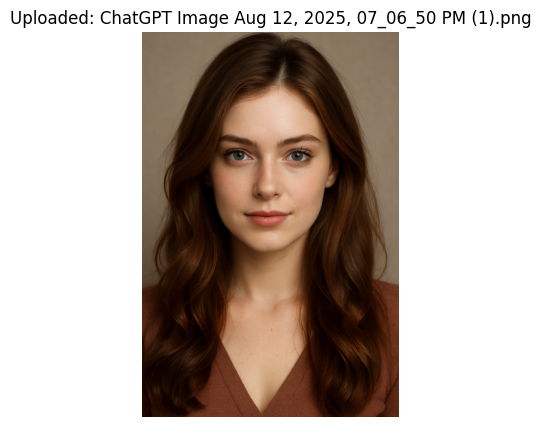

Prediction: ai-generated (confidence: 0.2150)


In [18]:
from google.colab import files
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

# Upload image(s)
uploaded = files.upload()  # Opens file upload dialog

for fn in uploaded.keys():
    # Open and display the image
    img = Image.open(fn)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Uploaded: {fn}")
    plt.show()

    # Predict
    label, confidence = predict_image(fn)
    print(f"Prediction: {label} (confidence: {confidence:.4f})")


Saving ChatGPT Image Aug 12, 2025, 08_01_02 PM.png to ChatGPT Image Aug 12, 2025, 08_01_02 PM (4).png


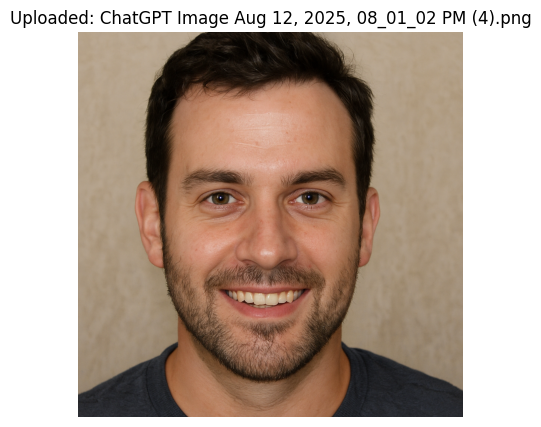

Prediction: ai-generated (confidence: 0.3800)


In [20]:
from google.colab import files
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

# Upload image(s)
uploaded = files.upload()  # Opens file upload dialog

for fn in uploaded.keys():
    # Open and display the image
    img = Image.open(fn)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Uploaded: {fn}")
    plt.show()

    # Predict
    label, confidence = predict_image(fn)
    print(f"Prediction: {label} (confidence: {confidence:.4f})")


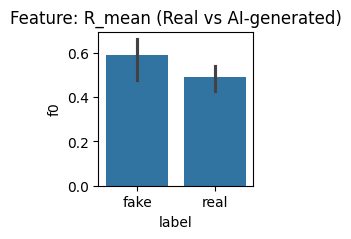

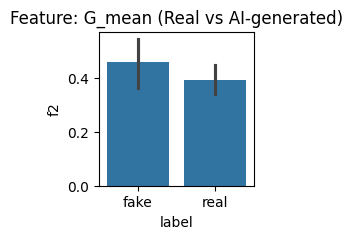

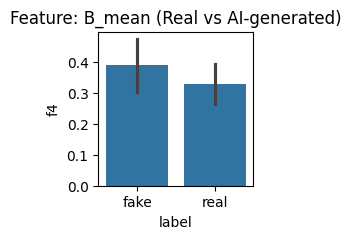

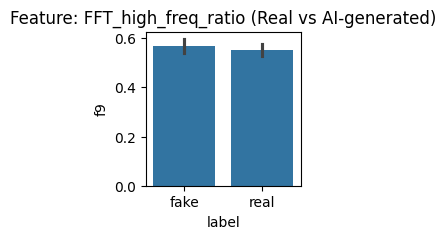

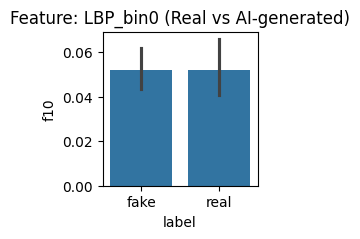

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pick a small balanced sample (e.g., 5 real + 5 fake)
sample_df = feats_df.groupby('label').sample(5, random_state=42)

# Select key features to visualize
# For demonstration, we take:
# - R channel mean, G channel mean, B channel mean
# - FFT high-frequency ratio
# - LBP first bin
key_features = ['f0', 'f2', 'f4', 'f9', 'f10']
feature_names = ['R_mean','G_mean','B_mean','FFT_high_freq_ratio','LBP_bin0']

# Plot feature distributions
for i, feat in enumerate(key_features):
    plt.figure(figsize=(2,2))
    sns.barplot(x='label', y=feat, data=sample_df)
    plt.title(f"Feature: {feature_names[i]} (Real vs AI-generated)")
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

joblib.dump(model, "/content/drive/MyDrive/rf_forensic_dct_model.joblib")
joblib.dump(scaler, "/content/drive/MyDrive/rf_forensic_dct_scaler.joblib")
print("Saved model and scaler to Google Drive.")


Mounted at /content/drive
Saved model and scaler to Google Drive.


In [24]:
import zipfile
from google.colab import files
import os

# Files to include (ensure they exist)
files_to_zip = ["rf_forensic_model.joblib",
                "rf_forensic_scaler.joblib",
                "features_merged.csv"]

zip_name = "real-vs-ai-proj.zip"

with zipfile.ZipFile(zip_name, 'w') as zipf:
    for f in files_to_zip:
        if os.path.exists(f):
            zipf.write(f)
            print(f"Added {f} to {zip_name}")
        else:
            print(f"Skipped {f} (file not found)")

print(f"Created zip file: {zip_name}")

# Download ZIP
files.download(zip_name)


Added rf_forensic_model.joblib to real-vs-ai-proj.zip
Added rf_forensic_scaler.joblib to real-vs-ai-proj.zip
Added features_merged.csv to real-vs-ai-proj.zip
Created zip file: real-vs-ai-proj.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>